# New_GT points preprocessing and testing

In [64]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
def new_GT_initial_preprocess():
    
    all_shp_fls = np.array(glob(r'data_files\krishna\**\*.shp', recursive=True))
    pol_shp_files = [files for files in all_shp_fls if 'point' not in files]
    pol_shp_files.remove(pol_shp_files[-2])

    series = pd.Series(gp.read_file(pol_shp_files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    columns = ['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'label']
    
    tst_pol_wheat = pd.DataFrame(columns = columns)
    tst_pol_mustard = pd.DataFrame(columns = columns)

    for file in pol_shp_files:
        temp = gp.read_file(file)[ndvi_cols[1:11]]
        temp.columns = columns[:-1]
        # temp['district'] = 'SHIVPURI' * temp.shape[0]
        if 'Wheat' in file:
            temp['label'] = [1]*temp.shape[0]
            tst_pol_wheat = pd.concat([tst_pol_wheat, temp],ignore_index=True)
        else:
            temp['label'] = [0]*temp.shape[0]
            tst_pol_mustard = pd.concat([tst_pol_mustard, temp], ignore_index=True)
            
    tst_pol_wheat.iloc[:,:-1] = tst_pol_wheat.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol_mustard.iloc[:,:-1] = tst_pol_mustard.iloc[:,:-1].apply(lambda row:round(row*100+100))
    tst_pol = pd.concat([tst_pol_wheat, tst_pol_mustard], ignore_index=True)
    
    return tst_pol

In [66]:
# tst_pol[tst_pol.label == 1].iloc[:,:-1].sample(10, random_state=42).T.plot()
# # plt.legend()
# # plt.xlabel(tst_pol.columns[:-1])
# plt.show()

# Approach 1 - With outliers

In [67]:
tst_pol = new_GT_initial_preprocess()

In [68]:
X_tst_pol = tst_pol.drop('label', axis=1)
y_tst_pol = tst_pol['label']

scaler = pickle.load(open(r'models/Binary_StandardScaler_1.1', 'rb'))

X_tst_pol = pd.DataFrame(scaler.transform(X_tst_pol), columns=X_tst_pol.columns)

y_tst_pol = y_tst_pol.astype(int)

<Axes: >

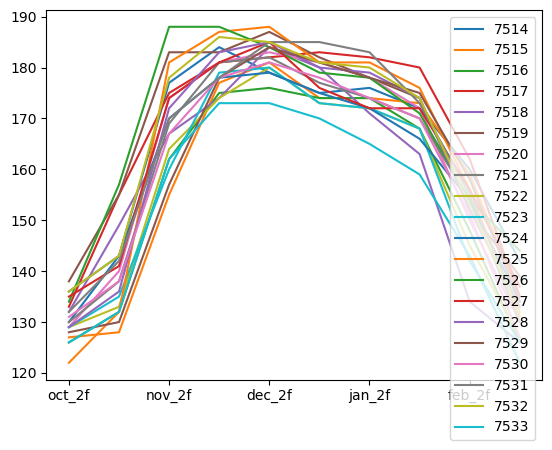

In [63]:
tst_pol[tst_pol.label == 0].iloc[:20,:-1].T.plot()

In [56]:
tst_pol.iloc[:20,:-1].T.plot()

0     0
1     0
2     1
3     0
4     1
5     0
6     0
7     0
8     0
9     1
10    1
11    0
12    0
13    0
14    1
15    1
16    0
17    0
18    0
19    0
dtype: int32

In [57]:
y_tst_pol[:20]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
Name: label, dtype: int32

In [69]:
from copy import deepcopy
from glob import glob

test_recall_scores = []
confusion_matrices = []
y_hat = []
test_dfs = []

model_paths = [path for path in glob('models\\**') if 'XGB_Binary' in path]

for path in model_paths:
    
    strt_col, end_col = path.split('-')[0][-6:], path.split('-')[1][:6]
    temp_X_test = X_tst_pol.loc[:,strt_col:end_col]    
    model = pickle.load(open(path, 'rb'))
    test_pred = model.predict(temp_X_test)
    y_hat.append(pd.Series(test_pred))
    precision, recall, f1score, support = score(y_tst_pol, test_pred, labels=[0,1])
    test_recall_scores.append([strt_col+'-'+end_col, round(recall[0], 2), round(recall[1], 2)])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_tst_pol, test_pred), 
                         columns=['Non-Wheat', 'Wheat'], 
                         index=['Non-Wheat', 'Wheat']))
    df = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df['correct_pred(%)'] = round(df['correct_pred']/df['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df = pd.concat([df, temp_df], axis=1)
    test_dfs.append(df)
    print(test_recall_scores[-1])

['oct_2f-dec_1f', 1.0, 0.58]
['oct_2f-dec_2f', 1.0, 0.51]
['oct_2f-feb_1f', 1.0, 0.54]
['oct_2f-feb_2f', 1.0, 0.46]
['oct_2f-jan_1f', 1.0, 0.55]
['oct_2f-jan_2f', 1.0, 0.43]
['oct_2f-mar_1f', 1.0, 0.36]


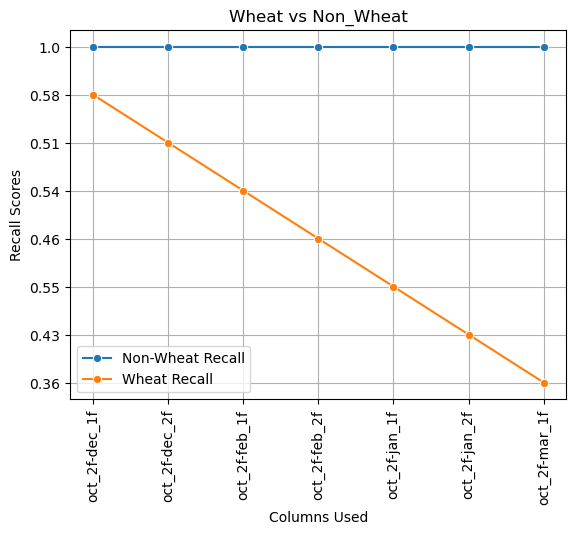

In [70]:
test_recall_scores = np.array(test_recall_scores)

sns.lineplot(y=test_recall_scores[:,1], x=test_recall_scores[:,0], label='Non-Wheat Recall', marker="o")
sns.lineplot(y=test_recall_scores[:,2], x=test_recall_scores[:,0], label ='Wheat Recall', marker="o")
plt.xlabel('Columns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.grid()
plt.show()

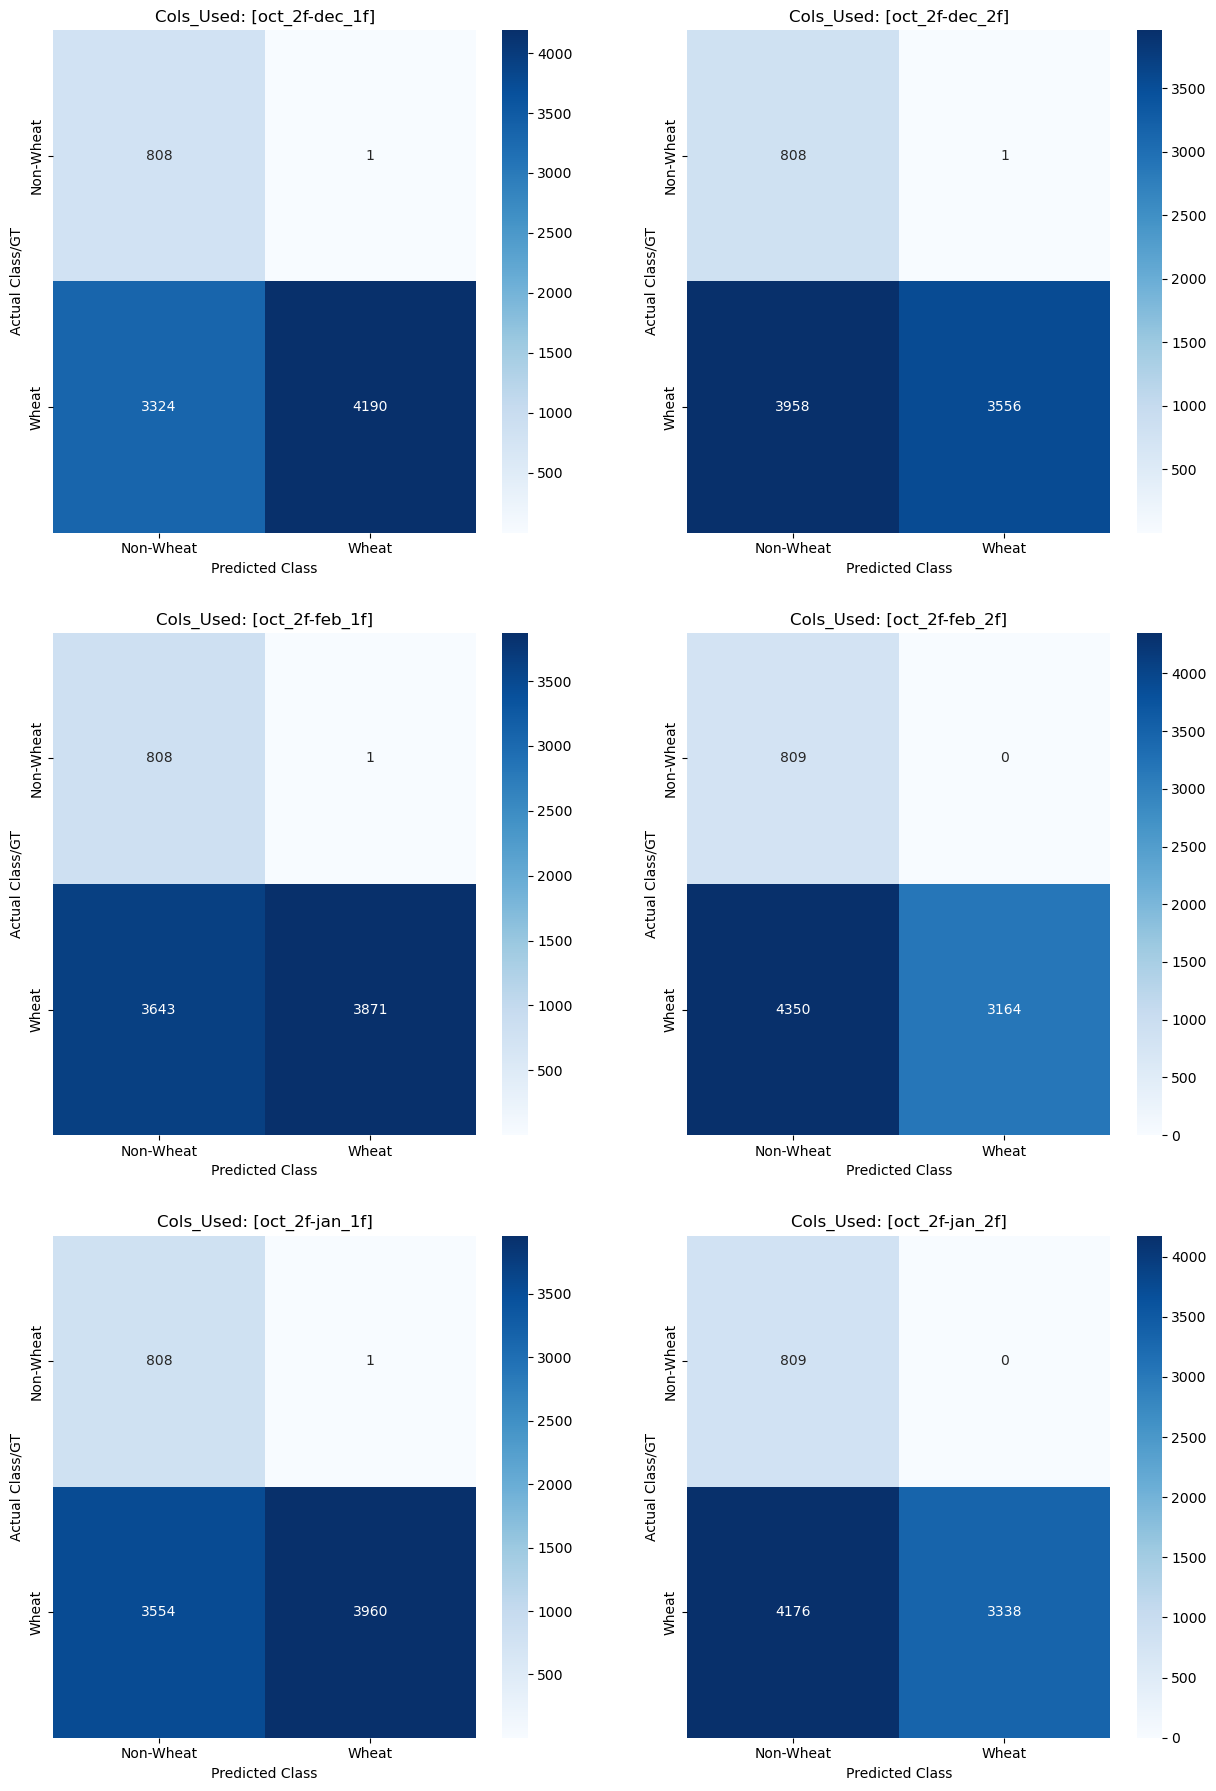

In [20]:
plt.figure(figsize=(15,30))
columns_used = test_recall_scores[:,0]
for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_Used: [{columns_used[i]}]')
plt.show()

In [26]:
j = 1
plt.figure(figsize=(15,40))
for i in range(len(y_hat)):
    ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
    corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
    ic_ndvi_df = ic[ic.label == 0].sample(10, random_state=42).iloc[:,:-(i+1)]
    corr_ndvi_df = corr[corr.label == 0].sample(10, random_state=42).iloc[:,:-(i+1)]
    plt.subplot(7,2,j)
    sns.lineplot(corr_ndvi_df.T).set(title='Correct_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    plt.subplot(7,2,j+1)
    sns.lineplot(ic_ndvi_df.T).set(title='Incorrect_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    j += 2
plt.show()

ValueError: a must be greater than 0 unless no samples are taken

<Figure size 1500x4000 with 0 Axes>

# Approach 2 - Imputing outliers

In [27]:
tst_pol = new_GT_initial_preprocess()

In [28]:
def outlier_imputation(group):
    group[(group < 100) | (group > 190)] = round(group.mean())
    return group

tst_pol.iloc[:,:-1] = tst_pol.groupby('label').transform(outlier_imputation)

In [29]:
X_tst_pol = tst_pol.drop('label', axis=1)
y_tst_pol = tst_pol['label']

scaler = pickle.load(open(r'models/Binary_StandardScaler_1.1', 'rb'))

X_tst_pol = pd.DataFrame(scaler.transform(X_tst_pol), columns=X_tst_pol.columns)

y_tst_pol = y_tst_pol.astype(int)

In [30]:
from copy import deepcopy
from glob import glob

test_recall_scores = []
confusion_matrices = []
y_hat = []
test_dfs = []

model_paths = [path for path in glob('models\\**') if 'XGB_Binary' in path]

for path in model_paths:
    
    strt_col, end_col = path.split('-')[0][-6:], path.split('-')[1][:6]
    temp_X_test = X_tst_pol.loc[:,strt_col:end_col]    
    model = pickle.load(open(path, 'rb'))
    test_pred = model.predict(temp_X_test)
    y_hat.append(pd.Series(test_pred))
    precision, recall, f1score, support = score(y_tst_pol, test_pred, labels=[0,1])
    test_recall_scores.append([strt_col+'-'+end_col, recall[0], recall[1]])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_tst_pol, test_pred), 
                         columns=['Non-Wheat', 'Wheat'], 
                         index=['Non-Wheat', 'Wheat']))
    df = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df['correct_pred(%)'] = round(df['correct_pred']/df['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df = pd.concat([df, temp_df], axis=1)
    test_dfs.append(df)
    print(test_recall_scores[-1])

['oct_2f-dec_1f', 0.9987639060568603, 0.5588235294117647]
['oct_2f-dec_2f', 0.9987639060568603, 0.44756454618046315]
['oct_2f-feb_1f', 0.9987639060568603, 0.44783071599680596]
['oct_2f-feb_2f', 1.0, 0.394729837636412]
['oct_2f-jan_1f', 0.9987639060568603, 0.41495874367846686]
['oct_2f-jan_2f', 1.0, 0.3758317806760713]
['oct_2f-mar_1f', 1.0, 0.314878892733564]


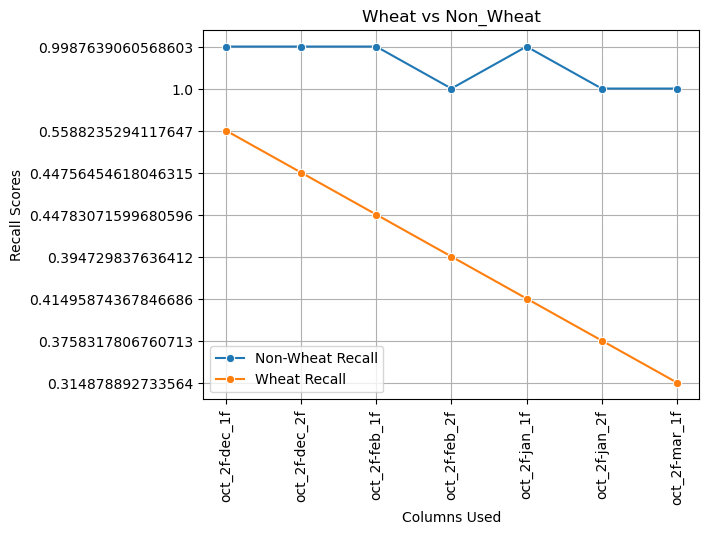

In [31]:
test_recall_scores = np.array(test_recall_scores)

sns.lineplot(y=test_recall_scores[:,1], x=test_recall_scores[:,0], label='Non-Wheat Recall', marker="o")
sns.lineplot(y=test_recall_scores[:,2], x=test_recall_scores[:,0], label ='Wheat Recall', marker="o")
plt.xlabel('Columns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.grid()
plt.show()

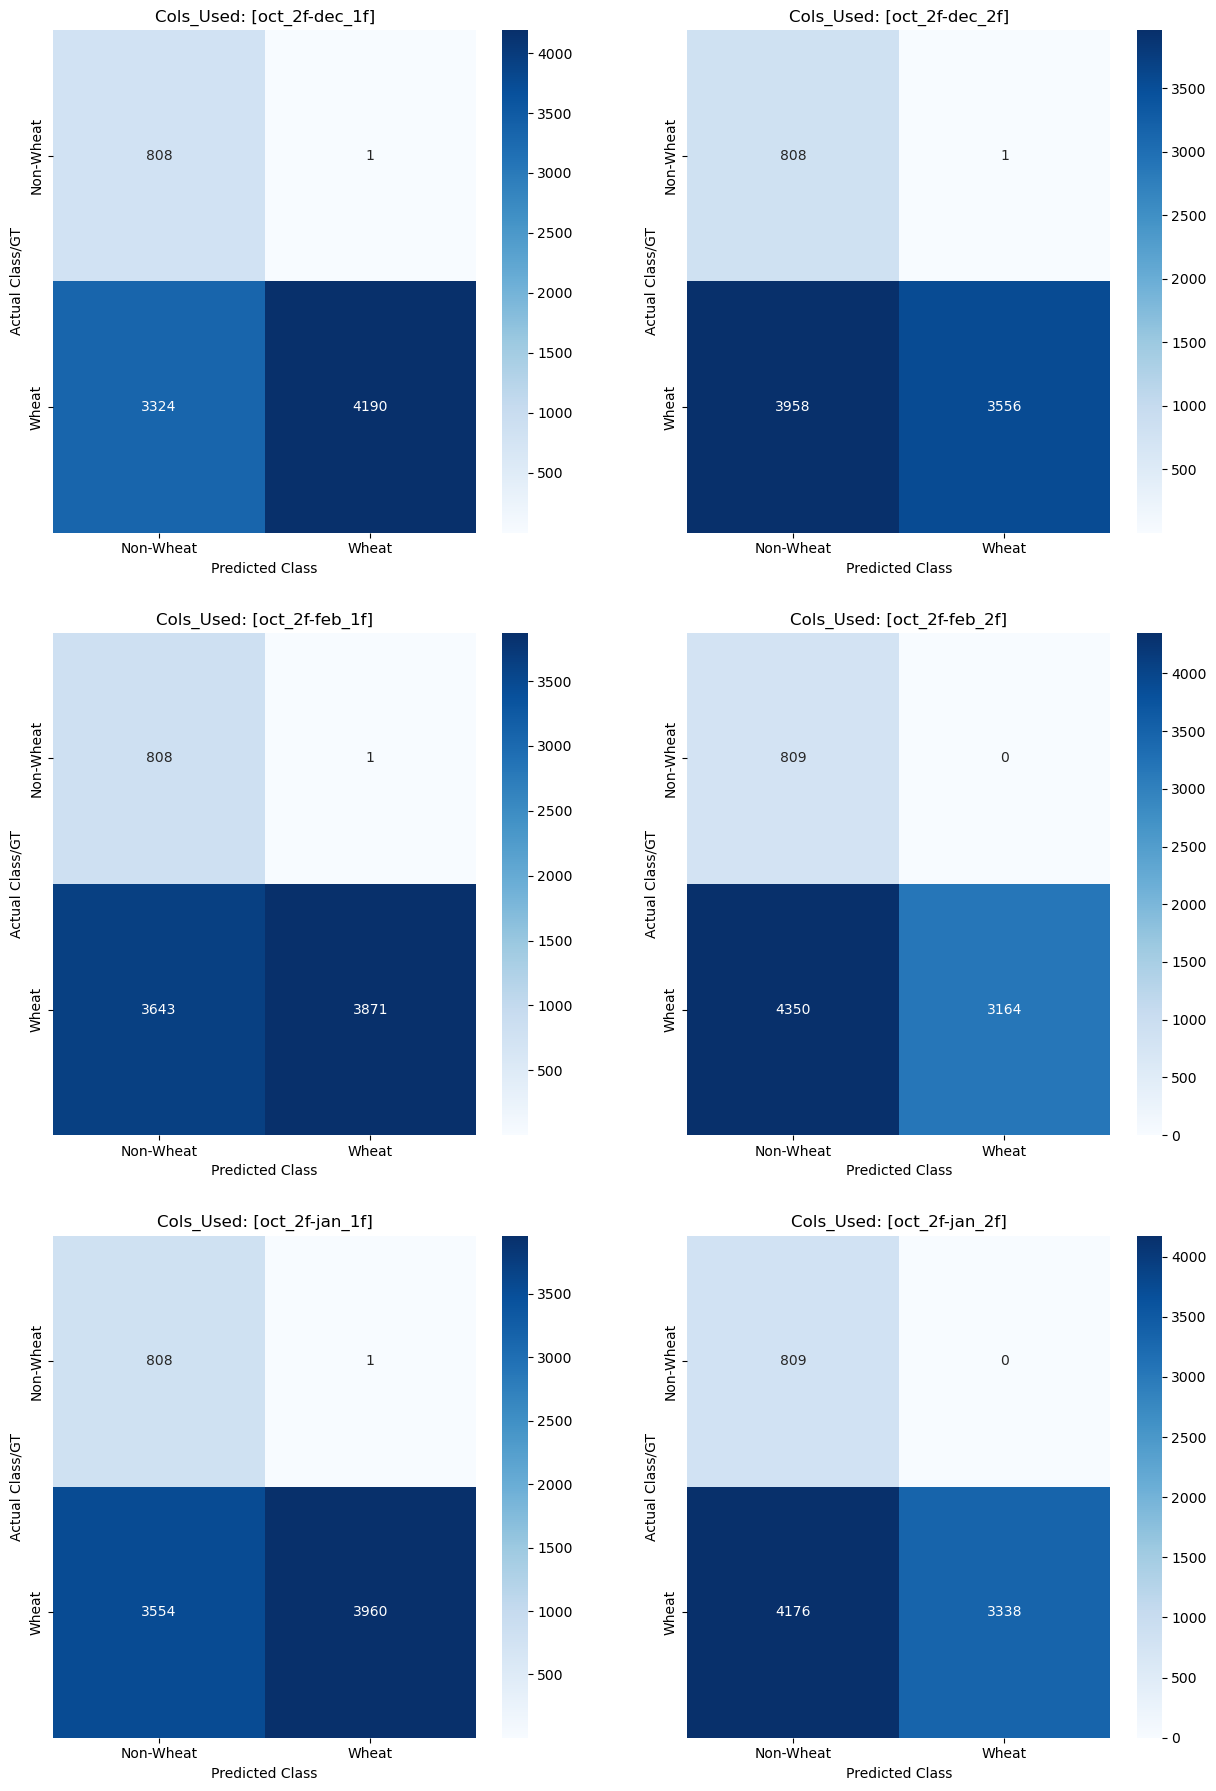

In [20]:
plt.figure(figsize=(15,30))
columns_used = test_recall_scores[:,0]
for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_Used: [{columns_used[i]}]')
plt.show()

In [265]:
inter = set(tst_pol[(y_hat[0] & y_tst_pol) == 0].index)
for i in y_hat[1:]:
    inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))

In [266]:
len(inter)

809

In [267]:
corr

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,label
0,178.0,152.0,124.0,125.0,136.0,161.0,169.0,183.0,184.0,182.0,1
1,176.0,157.0,141.0,136.0,123.0,148.0,160.0,185.0,187.0,187.0,1
2,165.0,141.0,133.0,135.0,156.0,169.0,175.0,187.0,189.0,186.0,1
3,128.0,133.0,124.0,131.0,124.0,142.0,155.0,187.0,188.0,187.0,1
4,173.0,136.0,127.0,127.0,139.0,170.0,177.0,186.0,186.0,185.0,1
...,...,...,...,...,...,...,...,...,...,...,...
7509,158.0,139.0,126.0,122.0,142.0,167.0,180.0,190.0,187.0,187.0,1
7510,163.0,141.0,123.0,123.0,143.0,172.0,180.0,189.0,187.0,186.0,1
7511,161.0,142.0,139.0,133.0,149.0,177.0,182.0,190.0,184.0,185.0,1
7512,157.0,131.0,131.0,134.0,152.0,180.0,182.0,189.0,180.0,181.0,1


In [268]:
j = 1
plt.figure(figsize=(15,40))
for i in range(len(y_hat)):
    ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
    corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
    ic_ndvi_df = ic[ic.label == 0].sample(10, random_state=42).iloc[:,:-(i+1)]
    corr_ndvi_df = corr[corr.label == 0].sample(10, random_state=42).iloc[:,:-(i+1)]
    plt.subplot(7,2,j)
    sns.lineplot(corr_ndvi_df.T).set(title='Correct_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    plt.subplot(7,2,j+1)
    sns.lineplot(ic_ndvi_df.T).set(title='Incorrect_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    j += 2
plt.show()

ValueError: a must be greater than 0 unless no samples are taken

<Figure size 1500x4000 with 0 Axes>

# Approach 3 - Removing outliers

In [ ]:
tst_pol = new_GT_initial_preprocess()

In [ ]:
outlier_indices = tst_pol[(tst_pol.iloc[:,:10].apply(lambda row : True if ((row < 100).sum() != 0) | ((row > 190).sum() != 0) else False, axis=1))].index

tst_pol.drop(outlier_indices, inplace=True)

In [ ]:
X_tst_pol = tst_pol.drop('label', axis=1)
y_tst_pol = tst_pol['label']

scaler = pickle.load(open(r'models/Binary_StandardScaler_1.1', 'rb'))

X_tst_pol = pd.DataFrame(scaler.transform(X_tst_pol), columns=X_tst_pol.columns)
y_tst_pol = y_tst_pol.astype(int)

In [ ]:
from copy import deepcopy
from glob import glob

test_recall_scores = []
confusion_matrices = []
y_hat = []

model_paths = [path for path in glob('models\\**') if 'Bin' in path]

for path in model_paths[:-1]:
    
    strt_col, end_col = '_'.join(path.split('_')[1:-1]).split('-')
    temp_X_test = X_tst_pol.loc[:,strt_col:end_col]    
    model = pickle.load(open(path, 'rb'))
    test_pred = model.predict(temp_X_test)
    y_hat.append(pd.Series(test_pred))
    precision, recall, f1score, support = score(y_tst_pol, test_pred, labels=[0,1])
    test_recall_scores.append([recall[0], recall[1]])
    confusion_matrices.append(pd.DataFrame(confusion_matrix(y_tst_pol, test_pred), 
                         columns=['Non-Wheat', 'Wheat'], 
                         index=['Non-Wheat', 'Wheat']))
    df = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df['correct_pred(%)'] = round(df['correct_pred']/df['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df = pd.concat([df, temp_df], axis=1)
    test_dfs.append(df)
    print(test_recall_scores[-1])

In [ ]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], 
             x=['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f'], 
             label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Columns Dropped')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(15,30))
columns_dropped = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']
for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Cols_dropped: [{columns_dropped[i]}]')
plt.show()

In [ ]:
inter = set(tst_pol[(y_hat[0] & y_tst_pol) == 0].index)
for i in y_hat[1:]:
    inter = inter.intersection(set(tst_pol[(i & y_tst_pol) == 0].index))

In [ ]:
len(inter)

In [ ]:
j = 1
plt.figure(figsize=(15,40))
for i in range(len(y_hat)):
    ic = tst_pol[((y_hat[i] & y_tst_pol) == 0)]
    corr = tst_pol[((y_hat[i] & y_tst_pol) == 1)]
    ic_ndvi_df = ic[ic.label == 1].sample(10, random_state=42).iloc[:,:-(i+1)]
    corr_ndvi_df = corr[corr.label == 1].sample(10, random_state=42).iloc[:,:-(i+1)]
    plt.subplot(7,2,j)
    sns.lineplot(corr_ndvi_df.T).set(title='Correct_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    plt.subplot(7,2,j+1)
    sns.lineplot(ic_ndvi_df.T).set(title='Incorrect_Pred')
    plt.xlabel('NDVI_FN')
    plt.ylabel('NDVI_Val')
    j += 2
plt.show()

In [ ]:
from IPython.display import display

x = ['0', 'mar_1f', 'mar_1f, feb_2f', 'mar_1f, feb_2f, feb_1f', 'mar_1f, feb_2f, feb_1f, jan_2f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f', 'mar_1f, feb_2f, feb_1f, jan_2f, jan_1f, dec_2f']

x *= 2

print("\033[1;31m" + 'New_pure_outlier_imputation')
print()
for i in range(len(test_dfs)):
    if i == 7:
        print("\033[1;31m" + 'New_pure_outlier_removal')
        print()
    print("\033[1;32m" + f'cols_dropped:[{x[i]}]')
    display(test_dfs[i])

In [71]:
tst_pol

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,label
0,178.0,152.0,124.0,125.0,136.0,161.0,169.0,183.0,184.0,182.0,1
1,176.0,157.0,141.0,136.0,123.0,148.0,160.0,185.0,187.0,187.0,1
2,165.0,141.0,133.0,135.0,156.0,169.0,175.0,187.0,189.0,186.0,1
3,128.0,133.0,124.0,131.0,124.0,142.0,155.0,187.0,188.0,187.0,1
4,173.0,136.0,127.0,127.0,139.0,170.0,177.0,186.0,186.0,185.0,1
...,...,...,...,...,...,...,...,...,...,...,...
8318,123.0,137.0,171.0,179.0,174.0,172.0,164.0,158.0,136.0,122.0,0
8319,123.0,153.0,174.0,176.0,173.0,173.0,168.0,159.0,133.0,119.0,0
8320,123.0,142.0,167.0,174.0,176.0,174.0,167.0,161.0,129.0,121.0,0
8321,151.0,181.0,182.0,179.0,179.0,181.0,171.0,144.0,133.0,126.0,0
